In [1]:
import os
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.step2_scaling import load_all_data
from shapely.geometry import mapping
import numpy as np
import rasterio
from rasterio.features import rasterize


In [3]:
dataset = load_all_data()
print(dataset)


Loading image 1 / 10
 → File: NL_1022.nc
 → Found 128 parcels
Available variables in NL_1022.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loading image 2 / 10
 → File: NL_1023.nc
 → Found 0 parcels
Available variables in NL_1023.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loading image 3 / 10
 → File: NL_1024.nc
 → Found 149 parcels
Available variables in NL_1024.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loading image 4 / 10
 → File: NL_1027.nc
 → Found 156 parcels
Available variables in NL_1027.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loading image 5 / 10
 → File: NL_1028.nc
 → Found 107 parcels
Available variables in NL_1028.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loading image 6 / 10
 → File: NL_1029.nc
 → Found 88 parcels
Available variables in NL_1029.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
 ✓ Step 2A Complete

Loadin

# Step 2B



In [4]:
import numpy as np
from rasterio import features
import rasterio
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt

import os
import sys
if '..' not in sys.path:
    sys.path.append('..')

from src.config import *
from src.data_loader import load_nc_image, load_mask, load_parcels   # your modules
#from step2_scaling import load_nc_image



# ------------------------------------------------------------
# Step 2B: Mask–Parcel Parity Check
# ------------------------------------------------------------

In [5]:
def mask_coverage(mask):
    """Return % of mask pixels that are >0."""
    return (mask > 0).mean() * 100

In [6]:
def raster_bounds(raster_path):
    """Return (minx, miny, maxx, maxy) of raster."""
    with rasterio.open(raster_path) as src:
        return src.bounds, src.transform

In [7]:
def parcel_mask_overlap(parcel_gdf, raster_path):
    """Compute which parcels intersect the raster bounding box."""
    ras_bounds, transform = raster_bounds(raster_path)
    ras_box = box(*ras_bounds)
    return parcel_gdf.intersects(ras_box)

In [8]:
def parcel_mask_pixel_coverage(parcel_gdf, mask, raster_path):
    """
    Compute pixel coverage for each parcel:
    % of parcel area that falls inside mask=1 pixels.
    """
    with rasterio.open(raster_path) as src:
        transform = src.transform

    results = []
    for idx, row in parcel_gdf.iterrows():
        geom = row.geometry
        # rasterize parcel geometry → boolean mask
        out_image = rasterio.features.rasterize(
            [(geom, 1)],
            out_shape=mask.shape,
            transform=transform,
            fill=0,
            dtype="uint8"
        )

        total = out_image.sum()
        overlap = ((out_image == 1) & (mask > 0)).sum()

        if total == 0:
            pct = 0
        else:
            pct = overlap / total * 100

        results.append((row["id"], pct))

    return results


# ------------------------------------------------------------
# Run on all images
# ------------------------------------------------------------
valid_images = []
report = []
big_gdf = gpd.read_file(os.path.join(VECTOR_DIR, "ai4boundaries_parcels_vector_sampled.gpkg"))


for fname in sorted(os.listdir(IMAGES_DIR)):
    if not fname.endswith(".nc"):
        continue

    image_id = int(fname.split("_")[1].split(".")[0])
    

    # skip images with no parcels
    parcels = load_parcels(big_gdf, image_id, country="Netherlands")
    if len(parcels) == 0:
        print(f"SKIP: {image_id} has no parcels.")
        continue

    # load mask
    mask_path = os.path.join(MASKS_DIR, f"NL_{image_id}.tif")
    mask = load_mask(mask_path)

    # compute mask coverage
    mc = mask_coverage(mask)

    # compute parcel-to-mask overlap
    parcel_overlap = parcel_mask_pixel_coverage(parcels, mask, mask_path)

    # store
    report.append({
        "image_id": image_id,
        "num_parcels": len(parcels),
        "mask_coverage_pct": mc,
        "parcel_overlap": parcel_overlap
    })

print("\n=== Step 2B Report Ready ===")

SKIP: 1023 has no parcels.
SKIP: 1100 has no parcels.

=== Step 2B Report Ready ===


# 2C 2. Rasterize parcels onto mask

In [9]:
# 2C
def rasterize_parcels_to_mask(parcel_gdf, reference_raster_path):
    with rasterio.open(reference_raster_path) as src:
        transform = src.transform
        height = src.height
        width = src.width
        crs = src.crs

    # Reproject parcels if needed
    if parcel_gdf.crs != crs:
        parcel_gdf = parcel_gdf.to_crs(crs)

    shapes = [(geom, 1) for geom in parcel_gdf.geometry]

    parcel_raster = rasterize(
        shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype="uint8"
    )

    return parcel_raster


In [10]:
# 2C
def compute_alignment_metrics(parcel_raster, mask):
    parcel_pixels = (parcel_raster == 1)
    mask_pixels = (mask > 0)

    total_parcel = parcel_pixels.sum()
    if total_parcel == 0:
        return {
            "parcel_pixels": 0,
            "overlap_pixels": 0,
            "overlap_pct": 0,
            "parcel_outside_mask_pct": 0
        }

    overlap = np.logical_and(parcel_pixels, mask_pixels).sum()
    outside = np.logical_and(parcel_pixels, np.logical_not(mask_pixels)).sum()

    return {
        "parcel_pixels": int(total_parcel),
        "overlap_pixels": int(overlap),
        "overlap_pct": overlap / total_parcel * 100,
        "parcel_outside_mask_pct": outside / total_parcel * 100
    }


In [11]:
# 2C
alignment_report = []

for entry in dataset:    # dataset is output of load_all_data()
    img_id = entry["id"]
    mask = entry["mask"]
    parcels = entry["parcels"]
    mask_path = entry["mask_path"]

    if len(parcels) == 0:
        print(f"Skip {img_id} (no parcels).")
        continue

    print(f"Step 2C: Checking alignment for {img_id}")

    parcel_raster = rasterize_parcels_to_mask(parcels, mask_path)
    metrics = compute_alignment_metrics(parcel_raster, mask)

    alignment_report.append({
        "image_id": img_id,
        **metrics
    })

print("\n=== Step 2C Alignment Report Complete ===")
alignment_report


Step 2C: Checking alignment for 1022
Skip 1023 (no parcels).
Step 2C: Checking alignment for 1024
Step 2C: Checking alignment for 1027
Step 2C: Checking alignment for 1028
Step 2C: Checking alignment for 1029
Step 2C: Checking alignment for 1031
Step 2C: Checking alignment for 1032
Step 2C: Checking alignment for 1099
Skip 1100 (no parcels).

=== Step 2C Alignment Report Complete ===


[{'image_id': 1022,
  'parcel_pixels': 4634,
  'overlap_pixels': 4634,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1024,
  'parcel_pixels': 8475,
  'overlap_pixels': 8475,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1027,
  'parcel_pixels': 9795,
  'overlap_pixels': 9795,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1028,
  'parcel_pixels': 13140,
  'overlap_pixels': 13140,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1029,
  'parcel_pixels': 2793,
  'overlap_pixels': 2793,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1031,
  'parcel_pixels': 45993,
  'overlap_pixels': 45993,
  'overlap_pct': np.float64(100.0),
  'parcel_outside_mask_pct': np.float64(0.0)},
 {'image_id': 1032,
  'parcel_pixels': 19416,
  'overlap_pixels': 19416,

# 2D 

In [12]:
from src.step2_scaling import load_nc_image, load_mask, load_parcels
from src.visualize import visualize_alignment
for item in alignment_report:

    img_id = item['image_id']
    print(f"Preparing visualization for {img_id}")

    # 1. Load NDVI + RGB
    nc_path = os.path.join(IMAGES_DIR, f"NL_{img_id}.nc")
    ndvi, rgb = load_nc_image(nc_path)

    # 2. Load mask
    mask_path = os.path.join(MASKS_DIR, f"NL_{img_id}.tif")
    mask = load_mask(mask_path)

    # 3. Load parcels
    parcels = load_parcels(big_gdf, img_id, "Netherlands")

    # 4. Now all inputs exist
    print("Shapes → RGB:", rgb.shape, " NDVI:", ndvi.shape, " MASK:", mask.shape)
    print("Parcels:", len(parcels))

    visualize_alignment(
    image_id=img_id,
    ndvi=ndvi,
    rgb=rgb,
    mask=mask,
    parcels=parcels,
    out_dir=RESULTS_DIR
)



Preparing visualization for 1022
Available variables in NL_1022.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
Shapes → RGB: (256, 256, 3)  NDVI: (256, 256)  MASK: (256, 256)
Parcels: 128
Saved alignment visualization: d:\project_alpha\notebooks\..\data\results\ALIGN_1022.png
Preparing visualization for 1024
Available variables in NL_1024.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
Shapes → RGB: (256, 256, 3)  NDVI: (256, 256)  MASK: (256, 256)
Parcels: 149
Saved alignment visualization: d:\project_alpha\notebooks\..\data\results\ALIGN_1024.png
Preparing visualization for 1027
Available variables in NL_1027.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
Shapes → RGB: (256, 256, 3)  NDVI: (256, 256)  MASK: (256, 256)
Parcels: 156
Saved alignment visualization: d:\project_alpha\notebooks\..\data\results\ALIGN_1027.png
Preparing visualization for 1028
Available variables in NL_1028.nc: ['B2', 'B3', 'B4', 'B8', 'NDVI', 'spatial_ref']
Shapes → RGB: (256, 256, 3)  NDVI: (25

# 2D.1 2D.1 — Superpixel + NDVI-guided centroid generation
Goal for each image:

Input: NDVI image (H×W), RGB image, ground truth mask

Run SLIC superpixels

Extract centroid of each superpixel

Use NDVI to filter or weight centroids (optional at first)

Output: a list of points → [ [x, y], [x, y], ... ]

This becomes the prompt_points for SAM.

In [13]:
# Build images_dict needed for Step 2D
images_dict = {}

for entry in dataset:
    img_id = entry["id"]

    if entry["rgb"] is None or entry["ndvi"] is None or entry["mask"] is None:
        print(f"Skipping {img_id}: missing RGB/NDVI/mask")
        continue

    images_dict[img_id] = {
        "rgb": entry["rgb"],
        "ndvi": entry["ndvi"],
        "mask": entry["mask"]
    }

print(f"images_dict built with {len(images_dict)} images.")


images_dict built with 10 images.


In [14]:
images_dict

{1022: {'rgb': array([[[0.13296281, 0.18255664, 0.1432236 ],
          [0.13381787, 0.18426678, 0.14920907],
          [0.13467294, 0.18255664, 0.15134673],
          ...,
          [0.09405729, 0.1509192 , 0.13317657],
          [0.09320223, 0.14707139, 0.129115  ],
          [0.13381787, 0.16930312, 0.15476699]],
  
         [[0.14215477, 0.20692603, 0.16973065],
          [0.13958956, 0.19965798, 0.17186832],
          [0.1361693 , 0.19538264, 0.17101325],
          ...,
          [0.09320223, 0.14985037, 0.13574177],
          [0.10004275, 0.15989739, 0.12868747],
          [0.10282172, 0.16524155, 0.14621633]],
  
         [[0.1425823 , 0.21504916, 0.17785378],
          [0.13958956, 0.21120137, 0.16951689],
          [0.13723813, 0.2064985 , 0.16117999],
          ...,
          [0.10880718, 0.16951689, 0.13445917],
          [0.10880718, 0.16973065, 0.1464301 ],
          [0.10880718, 0.16973065, 0.1464301 ]],
  
         ...,
  
         [[0.34138522, 0.32962805, 0.21825567],
 

In [15]:
from src.step2_superpixels import run_superpixel_generation_for_all

run_superpixel_generation_for_all(images_dict)



[2D.1] Processing 1022 ...
[2D.1] Saved centroids for 1022: 289 points

[2D.1] Processing 1023 ...
[2D.1] Saved centroids for 1023: 289 points

[2D.1] Processing 1024 ...
[2D.1] Saved centroids for 1024: 289 points

[2D.1] Processing 1027 ...
[2D.1] Saved centroids for 1027: 289 points

[2D.1] Processing 1028 ...
[2D.1] Saved centroids for 1028: 289 points

[2D.1] Processing 1029 ...
[2D.1] Saved centroids for 1029: 289 points

[2D.1] Processing 1031 ...
[2D.1] Saved centroids for 1031: 289 points

[2D.1] Processing 1032 ...
[2D.1] Saved centroids for 1032: 289 points

[2D.1] Processing 1099 ...
[2D.1] Saved centroids for 1099: 289 points

[2D.1] Processing 1100 ...
[2D.1] Saved centroids for 1100: 289 points

=== Step 2D.1 Completed: Superpixel prompts generated ===


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6977611780166626..1.0].


Testing images: [1022, 1023, 1024]

===== ANALYSIS FOR IMAGE 1022 =====
NDVI Mean: -0.0463
NDVI Variance: 0.1100
NDVI Min/Max: -0.7173 / 0.8816
SLIC segments returned: 289


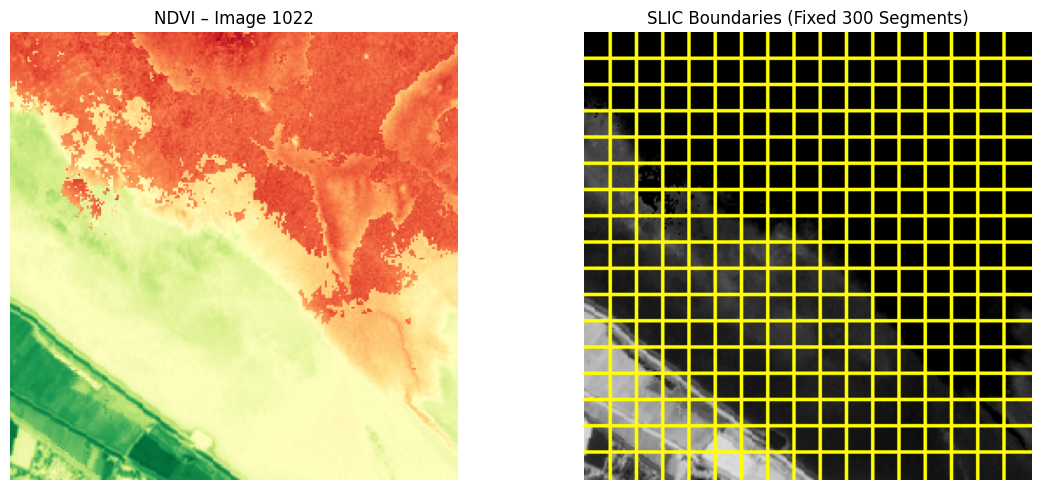

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7165918350219727..1.0].



===== ANALYSIS FOR IMAGE 1023 =====
NDVI Mean: -0.3387
NDVI Variance: 0.0073
NDVI Min/Max: -0.7166 / 0.2727
SLIC segments returned: 289


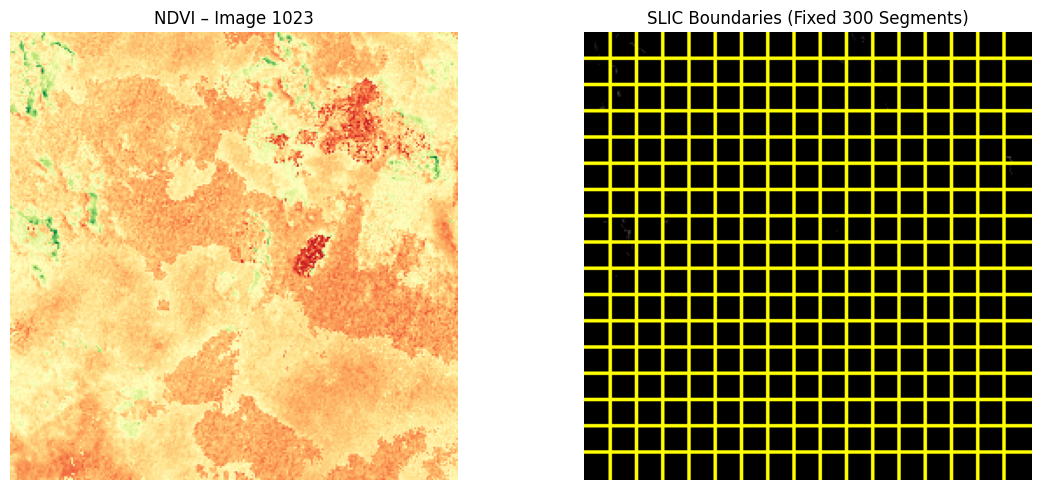


===== ANALYSIS FOR IMAGE 1024 =====
NDVI Mean: -0.1161
NDVI Variance: 0.1616
NDVI Min/Max: -0.8320 / 0.8767


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8320072889328003..1.0].


SLIC segments returned: 289


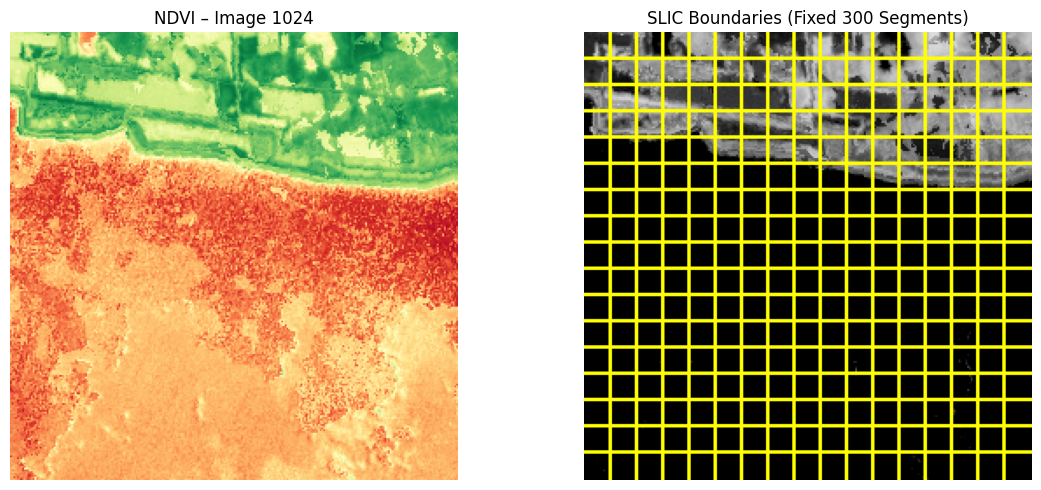

In [17]:
# Tests
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries

# Pick a few images from dataset
sample_ids = [dataset[0]["id"], dataset[1]["id"], dataset[2]["id"]]
print("Testing images:", sample_ids)

def analyze_image(entry):

    img_id = entry["id"]
    ndvi = entry["ndvi"].astype(float)

    print(f"\n===== ANALYSIS FOR IMAGE {img_id} =====")

    # ---------- Test 1: NDVI Stats ----------
    mean_ndvi = np.mean(ndvi)
    var_ndvi = np.var(ndvi)
    min_ndvi = np.min(ndvi)
    max_ndvi = np.max(ndvi)

    print(f"NDVI Mean: {mean_ndvi:.4f}")
    print(f"NDVI Variance: {var_ndvi:.4f}")
    print(f"NDVI Min/Max: {min_ndvi:.4f} / {max_ndvi:.4f}")

    # ---------- Test 2: Run SLIC (current method) ----------
    segments = slic(ndvi, n_segments=300, compactness=10, start_label=1, channel_axis=None)
    n_segments_real = len(np.unique(segments))

    print(f"SLIC segments returned: {n_segments_real}")

    # ---------- Test 3: Visualize NDVI + SLIC Boundaries ----------
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].imshow(ndvi, cmap="RdYlGn")
    ax[0].set_title(f"NDVI – Image {img_id}")
    ax[0].axis("off")

    ax[1].imshow(mark_boundaries(ndvi, segments))
    ax[1].set_title(f"SLIC Boundaries (Fixed 300 Segments)")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Run for selected images
for entry in dataset[:3]:
    analyze_image(entry)
